In [16]:
## THIS VERSION MAKES A NEW PLOT FOR EACH UPDATE; NOT IDEAL ##

import socket
import time
import pylsl
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.animation as animation
%matplotlib inline

# SELECT DATA TO STREAM
acc = False      # 3-axis acceleration
bvp = False      # Blood Volume Pulse
gsr = False      # Galvanic Skin Response (Electrodermal Activity)
tmp = True       # Temperature
ibi = False      # Interbeat Interval and Heartbeat
bat = False      # Device Battery
tag = False      # Tag taken from the device (by pressing the button)

serverAddress = '127.0.0.1'
serverPort = 28000
bufferSize = 4096

deviceID = 'CDCB11' # 'A03003'

def connect():
    global s
    s = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
    s.settimeout(3)

    print("Connecting to server")
    s.connect((serverAddress, serverPort))
    print("Connected to server\n")

    print("Devices available:")
    s.send("device_list\r\n".encode())
    response = s.recv(bufferSize)
    print(response.decode("utf-8"))

    print("Connecting to device")
    s.send(("device_connect " + deviceID + "\r\n").encode())
    response = s.recv(bufferSize)
    print(response.decode("utf-8"))

    print("Pausing data receiving")
    s.send("pause ON\r\n".encode())
    response = s.recv(bufferSize)
    print(response.decode("utf-8"))
connect()

time.sleep(1)

def suscribe_to_data():
    if acc:
        print("Suscribing to ACC")
        s.send(("device_subscribe " + 'acc' + " ON\r\n").encode())
        response = s.recv(bufferSize)
        print(response.decode("utf-8"))
    if bvp:
        print("Suscribing to BVP")
        s.send(("device_subscribe " + 'bvp' + " ON\r\n").encode())
        response = s.recv(bufferSize)
        print(response.decode("utf-8"))
    if gsr:
        print("Suscribing to GSR")
        s.send(("device_subscribe " + 'gsr' + " ON\r\n").encode())
        response = s.recv(bufferSize)
        print(response.decode("utf-8"))
    if tmp:
        print("Suscribing to Temp")
        s.send(("device_subscribe " + 'tmp' + " ON\r\n").encode())
        response = s.recv(bufferSize)
        print(response.decode("utf-8"))
    if ibi:
        print("Suscribing to IBI")
        s.send(("device_subscribe " + 'ibi' + " ON\r\n").encode())
        response = s.recv(bufferSize)
        print(response.decode("utf-8"))
    if bat:
        print("Suscribing to Batt")
        s.send(("device_subscribe " + 'bat' + " ON\r\n").encode())
        response = s.recv(bufferSize)
        print(response.decode("utf-8"))
    if tag:
        print("Suscribing to Tag")
        s.send(("device_subscribe " + 'tag' + " ON\r\n").encode())
        response = s.recv(bufferSize)
        print(response.decode("utf-8"))

    print("Resuming data receiving")
    s.send("pause OFF\r\n".encode())
    response = s.recv(bufferSize)
    print(response.decode("utf-8"))
suscribe_to_data()

time.sleep(1)

def reconnect():
    print("Reconnecting...")
    connect()
    suscribe_to_data()
    stream()

def prepare_LSL_streaming():
    #Arguments for pylsl.StreamInfo(NAME, TYPE, CHANNEL_COUNT, NOMINAL_SRATE, CHANNEL_FORMAT, SOURCE_ID)
    print("Starting LSL streaming")
    if acc:
        infoACC = pylsl.StreamInfo('acc','ACC',3,32,'int32','ACC-empatica_e4');
        global outletACC
        outletACC = pylsl.StreamOutlet(infoACC)
    if bvp:
        infoBVP = pylsl.StreamInfo('bvp','BVP',1,64,'float32','BVP-empatica_e4');
        global outletBVP
        outletBVP = pylsl.StreamOutlet(infoBVP)
    if gsr:
        infoGSR = pylsl.StreamInfo('gsr','GSR',1,4,'float32','GSR-empatica_e4');
        global outletGSR
        outletGSR = pylsl.StreamOutlet(infoGSR)
    if tmp:
        infoTemp = pylsl.StreamInfo('tmp','Temp',1,4,'float32','Temp-empatica_e4');
        global outletTemp
        outletTemp = pylsl.StreamOutlet(infoTemp)
    if ibi:
        infoIBI = pylsl.StreamInfo('ibi','IBI',1,0,'float32','IBI-empatica_e4');
        global outletIBI
        outletIBI = pylsl.StreamOutlet(infoIBI)
    if tag:
        infoTag = pylsl.StreamInfo('tag','Tag',1,0,'float32','Tag-empatica_e4');
        global outletTag
        outletTag = pylsl.StreamOutlet(infoTag)
    if bat:
        infoBatt = pylsl.StreamInfo('bat','Batt',1,0,'float32','Batt-empatica_e4');
        global outletBatt
        outletBatt = pylsl.StreamOutlet(infoBatt)
prepare_LSL_streaming()

global bvp_timestamp
bvp_timestamp = []
global bvp_data
bvp_data = []
temp_timestamp = []
temp_data = []

""" global fig
fig = plt.figure()
global ax
ax = fig.add_subplot(1, 1, 1)

def animate(i, xs, ys):

    # Read temperature (Celsius) from TMP102
    #temp_c = round(tmp102.read_temp(), 2)
    # NEEDS UPDATE HERE!

    # Add x and y to lists
    #xs.append(dt.datetime.now().strftime('%H:%M:%S.%f'))
    #ys.append(temp_c) 

    # Limit x and y lists to 1000 items
    xs = xs[-1000:]
    ys = ys[-1000:]

    # Draw x and y lists
    ax.clear()
    ax.plot(xs, ys)

    # Format plot
    plt.xticks(rotation=45, ha='right')
    plt.subplots_adjust(bottom=0.30)
    plt.title('E4 BVP over Time')
    plt.ylabel('BVP')  """


def stream():
    try:
        print("Streaming...")
        while True:
            try:
                response = s.recv(bufferSize).decode("utf-8")
                #print(response)
                if "connection lost to device" in response:
                    print(response.decode("utf-8"))
                    reconnect()
                    break
                samples = response.split("\n")
                for i in range(len(samples)-1):
                    stream_type = samples[i].split()[0]
                    """ if stream_type == "E4_Acc":
                        timestamp = float(samples[i].split()[1].replace(',','.'))
                        data = [int(samples[i].split()[2].replace(',','.')), int(samples[i].split()[3].replace(',','.')), int(samples[i].split()[4].replace(',','.'))]
                        outletACC.push_sample(data, timestamp=timestamp) """
                    if stream_type == "E4_Bvp":
                        bvp_new_timestamp = float(samples[i].split()[1].replace(',','.'))
                        bvp_new_data = float(samples[i].split()[2].replace(',','.'))
                        bvp_timestamp.append(bvp_new_timestamp)
                        bvp_data.append(bvp_new_data)                        
                    """ if stream_type == "E4_Gsr":
                        timestamp = float(samples[i].split()[1].replace(',','.'))
                        data = float(samples[i].split()[2].replace(',','.'))
                        outletGSR.push_sample([data], timestamp=timestamp) """
                    if stream_type == "E4_Temperature":
                        temp_new_timestamp = float(samples[i].split()[1].replace(',','.'))
                        temp_new_data = float(samples[i].split()[2].replace(',','.'))
                        temp_timestamp.append(temp_new_timestamp)
                        temp_data.append(temp_new_data)
                        timestamp = float(samples[i].split()[1].replace(',','.'))
                        data = float(samples[i].split()[2].replace(',','.'))
                        outletTemp.push_sample([data], timestamp=timestamp)
                    """ if stream_type == "E4_Ibi":
                        timestamp = float(samples[i].split()[1].replace(',','.'))
                        data = float(samples[i].split()[2].replace(',','.'))
                        outletIBI.push_sample([data], timestamp=timestamp) """
                    """ if stream_type == "E4_Tag":
                        timestamp = float(samples[i].split()[1].replace(',','.'))
                        data = float(samples[i].split()[2].replace(',','.'))
                        outletTag.push_sample([data], timestamp=timestamp) """
                    """ if stream_type == "E4_Battery":
                        timestamp = float(samples[i].split()[1].replace(',','.'))
                        data = float(samples[i].split()[2].replace(',','.'))
                        outletBatt.push_sample([data], timestamp=timestamp) """
                    fig = plt.figure()
                    ax = fig.add_subplot(1, 1, 1)

                    def animate(i, xs, ys):

                        # Read temperature (Celsius) from TMP102
                        #temp_c = round(tmp102.read_temp(), 2)
                        # NEEDS UPDATE HERE!

                        # Add x and y to lists
                        #xs.append(dt.datetime.now().strftime('%H:%M:%S.%f'))
                        #ys.append(temp_c) 

                        # Limit x and y lists to 20 items
                        xs = xs[-200:]
                        ys = ys[-200:]

                        # Draw x and y lists
                        ax.clear()
                        ax.plot(xs, ys)

                        # Format plot
                        plt.xticks(rotation=45, ha='right')
                        plt.subplots_adjust(bottom=0.30)
                        plt.title('E4 Temp over Time')
                        plt.ylabel('Temp') 
                    # Set up plot to call animate() function periodically
                    ani = animation.FuncAnimation(fig, animate, fargs=([dt.datetime.fromtimestamp(ts) for ts in temp_timestamp], temp_data), interval=10000)
                    plt.show()
                #time.sleep(1)
            except socket.timeout:
                print("Socket timeout")
                reconnect()
                break
    except KeyboardInterrupt:
        print("Disconnecting from device")
        s.send("device_disconnect\r\n".encode())
        s.close()
stream()


Connecting to server
Connected to server

Devices available:
R device_list 1 | CDCB11 Empatica_E4 

Connecting to device
R device_connect OK

Pausing data receiving
R pause ON

Suscribing to Temp
R device_subscribe tmp OK

Resuming data receiving
R pause OFF

Starting LSL streaming
Streaming...
Disconnecting from device


In [2]:
bvp_data[-1]

-0.1615906

In [15]:
## Similar to the above code, but I'm trying to use one plot that gets wiped and updated periodically ##


import socket
import time
import pylsl
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.animation as animation
%matplotlib qt

# SELECT DATA TO STREAM
acc = False      # 3-axis acceleration
bvp = False      # Blood Volume Pulse
gsr = False      # Galvanic Skin Response (Electrodermal Activity)
tmp = True       # Temperature
ibi = False      # Interbeat Interval and Heartbeat
bat = False      # Device Battery
tag = False      # Tag taken from the device (by pressing the button)

serverAddress = '127.0.0.1'
serverPort = 28000
bufferSize = 4096

deviceID = 'CDCB11' # 'A03003'

def connect():
    global s
    s = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
    s.settimeout(3)

    print("Connecting to server")
    s.connect((serverAddress, serverPort))
    print("Connected to server\n")

    print("Devices available:")
    s.send("device_list\r\n".encode())
    response = s.recv(bufferSize)
    print(response.decode("utf-8"))

    print("Connecting to device")
    s.send(("device_connect " + deviceID + "\r\n").encode())
    response = s.recv(bufferSize)
    print(response.decode("utf-8"))

    print("Pausing data receiving")
    s.send("pause ON\r\n".encode())
    response = s.recv(bufferSize)
    print(response.decode("utf-8"))
connect()

time.sleep(1)

def suscribe_to_data():
    if acc:
        print("Suscribing to ACC")
        s.send(("device_subscribe " + 'acc' + " ON\r\n").encode())
        response = s.recv(bufferSize)
        print(response.decode("utf-8"))
    if bvp:
        print("Suscribing to BVP")
        s.send(("device_subscribe " + 'bvp' + " ON\r\n").encode())
        response = s.recv(bufferSize)
        print(response.decode("utf-8"))
    if gsr:
        print("Suscribing to GSR")
        s.send(("device_subscribe " + 'gsr' + " ON\r\n").encode())
        response = s.recv(bufferSize)
        print(response.decode("utf-8"))
    if tmp:
        print("Suscribing to Temp")
        s.send(("device_subscribe " + 'tmp' + " ON\r\n").encode())
        response = s.recv(bufferSize)
        print(response.decode("utf-8"))
    if ibi:
        print("Suscribing to IBI")
        s.send(("device_subscribe " + 'ibi' + " ON\r\n").encode())
        response = s.recv(bufferSize)
        print(response.decode("utf-8"))
    if bat:
        print("Suscribing to Batt")
        s.send(("device_subscribe " + 'bat' + " ON\r\n").encode())
        response = s.recv(bufferSize)
        print(response.decode("utf-8"))
    if tag:
        print("Suscribing to Tag")
        s.send(("device_subscribe " + 'tag' + " ON\r\n").encode())
        response = s.recv(bufferSize)
        print(response.decode("utf-8"))

    print("Resuming data receiving")
    s.send("pause OFF\r\n".encode())
    response = s.recv(bufferSize)
    print(response.decode("utf-8"))
suscribe_to_data()

time.sleep(1)

def reconnect():
    print("Reconnecting...")
    connect()
    suscribe_to_data()
    stream()

def prepare_LSL_streaming():
    #Arguments for pylsl.StreamInfo(NAME, TYPE, CHANNEL_COUNT, NOMINAL_SRATE, CHANNEL_FORMAT, SOURCE_ID)
    print("Starting LSL streaming")
    if acc:
        infoACC = pylsl.StreamInfo('acc','ACC',3,32,'int32','ACC-empatica_e4');
        global outletACC
        outletACC = pylsl.StreamOutlet(infoACC)
    if bvp:
        infoBVP = pylsl.StreamInfo('bvp','BVP',1,64,'float32','BVP-empatica_e4');
        global outletBVP
        outletBVP = pylsl.StreamOutlet(infoBVP)
    if gsr:
        infoGSR = pylsl.StreamInfo('gsr','GSR',1,4,'float32','GSR-empatica_e4');
        global outletGSR
        outletGSR = pylsl.StreamOutlet(infoGSR)
    if tmp:
        infoTemp = pylsl.StreamInfo('tmp','Temp',1,4,'float32','Temp-empatica_e4');
        global outletTemp
        outletTemp = pylsl.StreamOutlet(infoTemp)
    if ibi:
        infoIBI = pylsl.StreamInfo('ibi','IBI',1,0,'float32','IBI-empatica_e4');
        global outletIBI
        outletIBI = pylsl.StreamOutlet(infoIBI)
    if tag:
        infoTag = pylsl.StreamInfo('tag','Tag',1,0,'float32','Tag-empatica_e4');
        global outletTag
        outletTag = pylsl.StreamOutlet(infoTag)
    if bat:
        infoBatt = pylsl.StreamInfo('bat','Batt',1,0,'float32','Batt-empatica_e4');
        global outletBatt
        outletBatt = pylsl.StreamOutlet(infoBatt)
prepare_LSL_streaming()

global bvp_timestamp
bvp_timestamp = []
global bvp_data
bvp_data = []
temp_timestamp = []
temp_data = []

plt.cla()

def stream():
    try:
        print("Streaming...")
        while True:
            try:
                response = s.recv(bufferSize).decode("utf-8")
                #print(response)
                if "connection lost to device" in response:
                    print(response.decode("utf-8"))
                    reconnect()
                    break
                samples = response.split("\n")
                for i in range(len(samples)-1):
                    stream_type = samples[i].split()[0]
                    """ if stream_type == "E4_Acc":
                        timestamp = float(samples[i].split()[1].replace(',','.'))
                        data = [int(samples[i].split()[2].replace(',','.')), int(samples[i].split()[3].replace(',','.')), int(samples[i].split()[4].replace(',','.'))]
                        outletACC.push_sample(data, timestamp=timestamp) """
                    if stream_type == "E4_Bvp":
                        bvp_new_timestamp = float(samples[i].split()[1].replace(',','.'))
                        bvp_new_data = float(samples[i].split()[2].replace(',','.'))
                        bvp_timestamp.append(bvp_new_timestamp)
                        bvp_data.append(bvp_new_data)                        
                    """ if stream_type == "E4_Gsr":
                        timestamp = float(samples[i].split()[1].replace(',','.'))
                        data = float(samples[i].split()[2].replace(',','.'))
                        outletGSR.push_sample([data], timestamp=timestamp) """
                    if stream_type == "E4_Temperature":
                        temp_new_timestamp = float(samples[i].split()[1].replace(',','.'))
                        temp_new_data = float(samples[i].split()[2].replace(',','.'))
                        temp_timestamp.append(temp_new_timestamp)
                        temp_data.append(temp_new_data)
                        timestamp = float(samples[i].split()[1].replace(',','.'))
                        data = float(samples[i].split()[2].replace(',','.'))
                        outletTemp.push_sample([data], timestamp=timestamp)
                    """ if stream_type == "E4_Ibi":
                        timestamp = float(samples[i].split()[1].replace(',','.'))
                        data = float(samples[i].split()[2].replace(',','.'))
                        outletIBI.push_sample([data], timestamp=timestamp) """
                    """ if stream_type == "E4_Tag":
                        timestamp = float(samples[i].split()[1].replace(',','.'))
                        data = float(samples[i].split()[2].replace(',','.'))
                        outletTag.push_sample([data], timestamp=timestamp) """
                    """ if stream_type == "E4_Battery":
                        timestamp = float(samples[i].split()[1].replace(',','.'))
                        data = float(samples[i].split()[2].replace(',','.'))
                        outletBatt.push_sample([data], timestamp=timestamp) """
                    #plt.cla()
                    #plt.pause(0.0005)
                    plt.pause(0.1)
                    #plt.subplot(211) 
                    plt.plot([dt.datetime.fromtimestamp(ts) for ts in temp_timestamp], temp_data, 'g') 
                    #plt.ylim(bottom = 26, top = 29)
                    """ plt.pause(0.0005)
                    plt.subplot(212)
                    plt.plot(bvp_timestamp, bvp_data, 'b') """
                    plt.show()
                #time.sleep(1)
            except socket.timeout:
                print("Socket timeout")
                reconnect()
                break
    except KeyboardInterrupt:
        print("Disconnecting from device")
        s.send("device_disconnect\r\n".encode())
        s.close()
stream()


Connecting to server
Connected to server

Devices available:
R device_list 1 | CDCB11 Empatica_E4 

Connecting to device
R device_connect OK

Pausing data receiving
R pause ON

Suscribing to Temp
R device_subscribe tmp OK

Resuming data receiving
R pause OFF

Starting LSL streaming
Streaming...
Disconnecting from device


In [14]:
# Trying to update plot in intervals (every 10 samples, etc)

import socket
import time
import pylsl
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.animation as animation
%matplotlib qt

# SELECT DATA TO STREAM
acc = False      # 3-axis acceleration
bvp = False      # Blood Volume Pulse
gsr = False      # Galvanic Skin Response (Electrodermal Activity)
tmp = True       # Temperature
ibi = False      # Interbeat Interval and Heartbeat
bat = False      # Device Battery
tag = False      # Tag taken from the device (by pressing the button)

serverAddress = '127.0.0.1'
serverPort = 28000
bufferSize = 4096

deviceID = 'CDCB11' # 'A03003'

def connect():
    global s
    s = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
    s.settimeout(3)

    print("Connecting to server")
    s.connect((serverAddress, serverPort))
    print("Connected to server\n")

    print("Devices available:")
    s.send("device_list\r\n".encode())
    response = s.recv(bufferSize)
    print(response.decode("utf-8"))

    print("Connecting to device")
    s.send(("device_connect " + deviceID + "\r\n").encode())
    response = s.recv(bufferSize)
    print(response.decode("utf-8"))

    print("Pausing data receiving")
    s.send("pause ON\r\n".encode())
    response = s.recv(bufferSize)
    print(response.decode("utf-8"))
connect()

time.sleep(1)

def suscribe_to_data():
    if acc:
        print("Suscribing to ACC")
        s.send(("device_subscribe " + 'acc' + " ON\r\n").encode())
        response = s.recv(bufferSize)
        print(response.decode("utf-8"))
    if bvp:
        print("Suscribing to BVP")
        s.send(("device_subscribe " + 'bvp' + " ON\r\n").encode())
        response = s.recv(bufferSize)
        print(response.decode("utf-8"))
    if gsr:
        print("Suscribing to GSR")
        s.send(("device_subscribe " + 'gsr' + " ON\r\n").encode())
        response = s.recv(bufferSize)
        print(response.decode("utf-8"))
    if tmp:
        print("Suscribing to Temp")
        s.send(("device_subscribe " + 'tmp' + " ON\r\n").encode())
        response = s.recv(bufferSize)
        print(response.decode("utf-8"))
    if ibi:
        print("Suscribing to IBI")
        s.send(("device_subscribe " + 'ibi' + " ON\r\n").encode())
        response = s.recv(bufferSize)
        print(response.decode("utf-8"))
    if bat:
        print("Suscribing to Batt")
        s.send(("device_subscribe " + 'bat' + " ON\r\n").encode())
        response = s.recv(bufferSize)
        print(response.decode("utf-8"))
    if tag:
        print("Suscribing to Tag")
        s.send(("device_subscribe " + 'tag' + " ON\r\n").encode())
        response = s.recv(bufferSize)
        print(response.decode("utf-8"))

    print("Resuming data receiving")
    s.send("pause OFF\r\n".encode())
    response = s.recv(bufferSize)
    print(response.decode("utf-8"))
suscribe_to_data()

time.sleep(1)

def reconnect():
    print("Reconnecting...")
    connect()
    suscribe_to_data()
    stream()

global bvp_timestamp
bvp_timestamp = []
global bvp_data
bvp_data = []
temp_timestamp = []
temp_data = []
global n
n = 0

def get_data():    
    while True:
        response = s.recv(bufferSize).decode("utf-8")
        #print(response)
        samples = response.split("\n")
        for i in range(len(samples)-1):
            global n
            n += 1
            stream_type = samples[i].split()[0]
            if stream_type == "E4_Temperature":
                temp_new_timestamp = float(samples[i].split()[1].replace(',','.'))
                temp_new_data = float(samples[i].split()[2].replace(',','.'))
                temp_timestamp.append(temp_new_timestamp)
                temp_data.append(temp_new_data)
            if n % 10 == 0:
                #plt.pause(0.1)
                plt.plot([dt.datetime.fromtimestamp(ts) for ts in temp_timestamp], temp_data, 'g')
                plt.show()
                plt.pause(0.1)    

get_data()         



Connecting to server
Connected to server

Devices available:
R device_list 1 | CDCB11 Empatica_E4 

Connecting to device
R device_connect OK

Pausing data receiving
R pause ON

Suscribing to Temp
R device_subscribe tmp OK

Resuming data receiving
R pause OFF



KeyboardInterrupt: 

In [10]:
## Trying to use foreground and background for the plot and datastream respectively
## Not working, runs for 2.2 seconds then stops everything


import socket
import time
import pylsl
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import threading
%matplotlib qt
#%matplotlib inline

# SELECT DATA TO STREAM
acc = False      # 3-axis acceleration
bvp = False      # Blood Volume Pulse
gsr = False      # Galvanic Skin Response (Electrodermal Activity)
tmp = True       # Temperature
ibi = False      # Interbeat Interval and Heartbeat
bat = False      # Device Battery
tag = False      # Tag taken from the device (by pressing the button)

serverAddress = '127.0.0.1'
serverPort = 28000
bufferSize = 4096

deviceID = 'CDCB11' # 'A03003'

def connect():
    global s
    s = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
    s.settimeout(3)

    print("Connecting to server")
    s.connect((serverAddress, serverPort))
    print("Connected to server\n")

    print("Devices available:")
    s.send("device_list\r\n".encode())
    response = s.recv(bufferSize)
    print(response.decode("utf-8"))

    print("Connecting to device")
    s.send(("device_connect " + deviceID + "\r\n").encode())
    response = s.recv(bufferSize)
    print(response.decode("utf-8"))

    print("Pausing data receiving")
    s.send("pause ON\r\n".encode())
    response = s.recv(bufferSize)
    print(response.decode("utf-8"))
connect()

time.sleep(1)

def suscribe_to_data():
    if acc:
        print("Suscribing to ACC")
        s.send(("device_subscribe " + 'acc' + " ON\r\n").encode())
        response = s.recv(bufferSize)
        print(response.decode("utf-8"))
    if bvp:
        print("Suscribing to BVP")
        s.send(("device_subscribe " + 'bvp' + " ON\r\n").encode())
        response = s.recv(bufferSize)
        print(response.decode("utf-8"))
    if gsr:
        print("Suscribing to GSR")
        s.send(("device_subscribe " + 'gsr' + " ON\r\n").encode())
        response = s.recv(bufferSize)
        print(response.decode("utf-8"))
    if tmp:
        print("Suscribing to Temp")
        s.send(("device_subscribe " + 'tmp' + " ON\r\n").encode())
        response = s.recv(bufferSize)
        print(response.decode("utf-8"))
    if ibi:
        print("Suscribing to IBI")
        s.send(("device_subscribe " + 'ibi' + " ON\r\n").encode())
        response = s.recv(bufferSize)
        print(response.decode("utf-8"))
    if bat:
        print("Suscribing to Batt")
        s.send(("device_subscribe " + 'bat' + " ON\r\n").encode())
        response = s.recv(bufferSize)
        print(response.decode("utf-8"))
    if tag:
        print("Suscribing to Tag")
        s.send(("device_subscribe " + 'tag' + " ON\r\n").encode())
        response = s.recv(bufferSize)
        print(response.decode("utf-8"))

    print("Resuming data receiving")
    s.send("pause OFF\r\n".encode())
    response = s.recv(bufferSize)
    print(response.decode("utf-8"))
suscribe_to_data()

time.sleep(1)

def reconnect():
    print("Reconnecting...")
    connect()
    suscribe_to_data()
    stream()

def prepare_LSL_streaming():
    #Arguments for pylsl.StreamInfo(NAME, TYPE, CHANNEL_COUNT, NOMINAL_SRATE, CHANNEL_FORMAT, SOURCE_ID)
    print("Starting LSL streaming")
    if acc:
        infoACC = pylsl.StreamInfo('acc','ACC',3,32,'int32','ACC-empatica_e4');
        global outletACC
        outletACC = pylsl.StreamOutlet(infoACC)
    if bvp:
        infoBVP = pylsl.StreamInfo('bvp','BVP',1,64,'float32','BVP-empatica_e4');
        global outletBVP
        outletBVP = pylsl.StreamOutlet(infoBVP)
    if gsr:
        infoGSR = pylsl.StreamInfo('gsr','GSR',1,4,'float32','GSR-empatica_e4');
        global outletGSR
        outletGSR = pylsl.StreamOutlet(infoGSR)
    if tmp:
        infoTemp = pylsl.StreamInfo('tmp','Temp',1,4,'float32','Temp-empatica_e4');
        global outletTemp
        outletTemp = pylsl.StreamOutlet(infoTemp)
    if ibi:
        infoIBI = pylsl.StreamInfo('ibi','IBI',1,0,'float32','IBI-empatica_e4');
        global outletIBI
        outletIBI = pylsl.StreamOutlet(infoIBI)
    if tag:
        infoTag = pylsl.StreamInfo('tag','Tag',1,0,'float32','Tag-empatica_e4');
        global outletTag
        outletTag = pylsl.StreamOutlet(infoTag)
    if bat:
        infoBatt = pylsl.StreamInfo('bat','Batt',1,0,'float32','Batt-empatica_e4');
        global outletBatt
        outletBatt = pylsl.StreamOutlet(infoBatt)
prepare_LSL_streaming()

global bvp_timestamp
bvp_timestamp = []
global bvp_data
bvp_data = []
temp_timestamp = []
temp_data = []


def stream():
    try:
        print("Streaming...")
        while True:
            try:
                response = s.recv(bufferSize).decode("utf-8")
                print(response)
                if "connection lost to device" in response:
                    print(response.decode("utf-8"))
                    reconnect()
                    break
                samples = response.split("\n")
                for i in range(len(samples)-1):
                    stream_type = samples[i].split()[0]
                    """ if stream_type == "E4_Acc":
                        timestamp = float(samples[i].split()[1].replace(',','.'))
                        data = [int(samples[i].split()[2].replace(',','.')), int(samples[i].split()[3].replace(',','.')), int(samples[i].split()[4].replace(',','.'))]
                        outletACC.push_sample(data, timestamp=timestamp) """
                    if stream_type == "E4_Bvp":
                        bvp_new_timestamp = float(samples[i].split()[1].replace(',','.'))
                        bvp_new_data = float(samples[i].split()[2].replace(',','.'))
                        bvp_timestamp.append(bvp_new_timestamp)
                        bvp_data.append(bvp_new_data)                        
                    """ if stream_type == "E4_Gsr":
                        timestamp = float(samples[i].split()[1].replace(',','.'))
                        data = float(samples[i].split()[2].replace(',','.'))
                        outletGSR.push_sample([data], timestamp=timestamp) """
                    if stream_type == "E4_Temperature":
                        temp_new_timestamp = float(samples[i].split()[1].replace(',','.'))
                        temp_new_data = float(samples[i].split()[2].replace(',','.'))
                        temp_timestamp.append(temp_new_timestamp)
                        temp_data.append(temp_new_data)
                        timestamp = float(samples[i].split()[1].replace(',','.'))
                        data = float(samples[i].split()[2].replace(',','.'))
                        outletTemp.push_sample([data], timestamp=timestamp)
                    """ if stream_type == "E4_Ibi":
                        timestamp = float(samples[i].split()[1].replace(',','.'))
                        data = float(samples[i].split()[2].replace(',','.'))
                        outletIBI.push_sample([data], timestamp=timestamp) """
                    """ if stream_type == "E4_Tag":
                        timestamp = float(samples[i].split()[1].replace(',','.'))
                        data = float(samples[i].split()[2].replace(',','.'))
                        outletTag.push_sample([data], timestamp=timestamp) """
                    """ if stream_type == "E4_Battery":
                        timestamp = float(samples[i].split()[1].replace(',','.'))
                        data = float(samples[i].split()[2].replace(',','.'))
                        outletBatt.push_sample([data], timestamp=timestamp) """
                #time.sleep(1)
            except socket.timeout:
                print("Socket timeout")
                reconnect()
                break
    except KeyboardInterrupt:
        print("Disconnecting from device")
        s.send("device_disconnect\r\n".encode())
        s.close()
#stream()



# This function is called periodically from FuncAnimation
def animate(i, xs, ys):


    # Limit x and y lists to 20 items
    #xs = xs[-20:]
    #ys = ys[-20:]

    # Draw x and y lists
    ax.clear()
    ax.plot(xs, ys)

    # Format plot
    plt.xticks(rotation=45, ha='right')
    plt.subplots_adjust(bottom=0.30)
    plt.title('Temperature over Time')
    plt.ylabel('Temperature (deg C)')

# Set up plot to call animate() function periodically
#ani = animation.FuncAnimation(fig, animate, fargs=(temp_timestamp, temp_data), interval=1000)
#plt.show()



def background():
    stream()

def foreground():
    # Create figure for plotting
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ani = animation.FuncAnimation(fig, animate, fargs=(temp_timestamp, temp_data), interval=1000)
    plt.show()

b = threading.Thread(name='background', target=background)
f = threading.Thread(name='foreground', target=foreground)

b.start()
f.start()


Connecting to server
Connected to server

Devices available:
R device_list 1 | CDCB11 Empatica_E4 

Connecting to device
R device_connect OK

Pausing data receiving
R pause ON

Suscribing to Temp
R device_subscribe tmp OK

Resuming data receiving
R pause OFF

Starting LSL streaming
Streaming...


In [45]:
disconnect()

# Use the code chunk below!

In [44]:
## Trying to use animation to get the data and update the plot
## Working for Temperature and BVP and streaming to LSL


import socket
import time
import pylsl
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation
import threading
%matplotlib qt
#%matplotlib inline

# SELECT DATA TO STREAM
acc = True      # 3-axis acceleration
bvp = True      # Blood Volume Pulse
gsr = True      # Galvanic Skin Response (Electrodermal Activity)
tmp = True      # Temperature
ibi = True      # Interbeat Interval and Heartbeat
bat = True      # Device Battery
tag = True      # Tag taken from the device (by pressing the button)

serverAddress = '127.0.0.1'
serverPort = 28000
bufferSize = 4096

deviceID = 'CDCB11' # 'A03003'

def connect():
    global s
    s = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
    s.settimeout(3)

    print("Connecting to server")
    s.connect((serverAddress, serverPort))
    print("Connected to server\n")

    print("Devices available:")
    s.send("device_list\r\n".encode())
    response = s.recv(bufferSize)
    print(response.decode("utf-8"))

    print("Connecting to device")
    s.send(("device_connect " + deviceID + "\r\n").encode())
    response = s.recv(bufferSize)
    print(response.decode("utf-8"))

    print("Pausing data receiving")
    s.send("pause ON\r\n".encode())
    response = s.recv(bufferSize)
    print(response.decode("utf-8"))
connect()

time.sleep(1)

def suscribe_to_data():
    if acc:
        print("Suscribing to ACC")
        s.send(("device_subscribe " + 'acc' + " ON\r\n").encode())
        response = s.recv(bufferSize)
        print(response.decode("utf-8"))
    if bvp:
        print("Suscribing to BVP")
        s.send(("device_subscribe " + 'bvp' + " ON\r\n").encode())
        response = s.recv(bufferSize)
        print(response.decode("utf-8"))
    if gsr:
        print("Suscribing to GSR")
        s.send(("device_subscribe " + 'gsr' + " ON\r\n").encode())
        response = s.recv(bufferSize)
        print(response.decode("utf-8"))
    if tmp:
        print("Suscribing to Temp")
        s.send(("device_subscribe " + 'tmp' + " ON\r\n").encode())
        response = s.recv(bufferSize)
        print(response.decode("utf-8"))
    if ibi:
        print("Suscribing to IBI")
        s.send(("device_subscribe " + 'ibi' + " ON\r\n").encode())
        response = s.recv(bufferSize)
        print(response.decode("utf-8"))
    if bat:
        print("Suscribing to Batt")
        s.send(("device_subscribe " + 'bat' + " ON\r\n").encode())
        response = s.recv(bufferSize)
        print(response.decode("utf-8"))
    if tag:
        print("Suscribing to Tag")
        s.send(("device_subscribe " + 'tag' + " ON\r\n").encode())
        response = s.recv(bufferSize)
        print(response.decode("utf-8"))

    print("Resuming data receiving")
    s.send("pause OFF\r\n".encode())
    response = s.recv(bufferSize)
    print(response.decode("utf-8"))
suscribe_to_data()

time.sleep(1)

def reconnect():
    print("Reconnecting...")
    connect()
    suscribe_to_data()
    #stream()

def disconnect():
    s.send("device_disconnect\r\n".encode())

def prepare_LSL_streaming():
    #Arguments for pylsl.StreamInfo(NAME, TYPE, CHANNEL_COUNT, NOMINAL_SRATE, CHANNEL_FORMAT, SOURCE_ID)
    print("Starting LSL streaming")
    if acc:
        infoACC = pylsl.StreamInfo('acc','ACC',3,32,'int32','ACC-empatica_e4');
        global outletACC
        outletACC = pylsl.StreamOutlet(infoACC)
    if bvp:
        infoBVP = pylsl.StreamInfo('bvp','BVP',1,64,'float32','BVP-empatica_e4');
        global outletBVP
        outletBVP = pylsl.StreamOutlet(infoBVP)
    if gsr:
        infoGSR = pylsl.StreamInfo('gsr','GSR',1,4,'float32','GSR-empatica_e4');
        global outletGSR
        outletGSR = pylsl.StreamOutlet(infoGSR)
    if tmp:
        infoTemp = pylsl.StreamInfo('tmp','Temp',1,4,'float32','Temp-empatica_e4');
        global outletTemp
        outletTemp = pylsl.StreamOutlet(infoTemp)
    if ibi:
        infoIBI = pylsl.StreamInfo('ibi','IBI',1,0,'float32','IBI-empatica_e4');
        global outletIBI
        outletIBI = pylsl.StreamOutlet(infoIBI)
    if tag:
        infoTag = pylsl.StreamInfo('tag','Tag',1,0,'float32','Tag-empatica_e4');
        global outletTag
        outletTag = pylsl.StreamOutlet(infoTag)
    if bat:
        infoBatt = pylsl.StreamInfo('bat','Batt',1,0,'float32','Batt-empatica_e4');
        global outletBatt
        outletBatt = pylsl.StreamOutlet(infoBatt)
prepare_LSL_streaming()

#global bvp_timestamp
bvp_timestamp = []
#global bvp_data
bvp_data = []
temp_timestamp = []
temp_data = []
acc_timestamp = []
acc_data = []
gsr_timestamp = []
gsr_data = []
#ibi_timestamp = []
#ibi_data = []


plt.style.use('fivethirtyeight')
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,1, sharex=True)


def animate(i):
    response = s.recv(bufferSize).decode("utf-8")
    #print(response)
    if "connection lost to device" in response:
        print(response.decode("utf-8"))
        reconnect()
    samples = response.split("\n")
    for i in range(len(samples)-1):
        stream_type = samples[i].split()[0]
        if stream_type == "E4_Bvp":
            bvp_new_timestamp = float(samples[i].split()[1].replace(',','.'))
            bvp_new_data = float(samples[i].split()[2].replace(',','.'))
            bvp_timestamp.append(bvp_new_timestamp)
            bvp_data.append(bvp_new_data)
            timestamp = float(samples[i].split()[1].replace(',','.'))
            data = float(samples[i].split()[2].replace(',','.'))
            outletBVP.push_sample([data], timestamp=timestamp)                        
        if stream_type == "E4_Temperature":
            temp_new_timestamp = float(samples[i].split()[1].replace(',','.'))
            temp_new_data = float(samples[i].split()[2].replace(',','.'))
            temp_timestamp.append(temp_new_timestamp)
            temp_data.append(temp_new_data)
            timestamp = float(samples[i].split()[1].replace(',','.'))
            data = float(samples[i].split()[2].replace(',','.'))
            outletTemp.push_sample([data], timestamp=timestamp)
        if stream_type == "E4_Acc":
            timestamp = float(samples[i].split()[1].replace(',','.'))
            data = [int(samples[i].split()[2].replace(',','.')), int(samples[i].split()[3].replace(',','.')), int(samples[i].split()[4].replace(',','.'))]
            acc_timestamp.append(timestamp)
            acc_data.append(data)
            outletACC.push_sample(data, timestamp=timestamp)
        if stream_type == "E4_Gsr":
            timestamp = float(samples[i].split()[1].replace(',','.'))
            data = float(samples[i].split()[2].replace(',','.'))
            gsr_timestamp.append(timestamp)
            gsr_data.append(data)
            outletGSR.push_sample([data], timestamp=timestamp)
        if stream_type == "E4_Ibi":
            timestamp = float(samples[i].split()[1].replace(',','.'))
            data = float(samples[i].split()[2].replace(',','.'))
            #ibi_timestamp.append(timestamp)
            #ibi_data.append(data)
            outletIBI.push_sample([data], timestamp=timestamp)
        if stream_type == "E4_Tag":
            timestamp = float(samples[i].split()[1].replace(',','.'))
            data = float(samples[i].split()[2].replace(',','.'))
            outletTag.push_sample([data], timestamp=timestamp)
        if stream_type == "E4_Battery":
            timestamp = float(samples[i].split()[1].replace(',','.'))
            data = float(samples[i].split()[2].replace(',','.'))
            outletBatt.push_sample([data], timestamp=timestamp)

    ax1.cla()
    ax1.plot([dt.datetime.fromtimestamp(ts) for ts in acc_timestamp], acc_data)
    ax1.set_ylabel('Acc (1/64 g)')
    #ax1.legend(iter(lineObjects), ('X', 'Y', 'Z'), loc='upper left')        
    
    ax2.cla()
    ax2.plot([dt.datetime.fromtimestamp(ts) for ts in bvp_timestamp], bvp_data)
    ax2.set_ylabel('BVP')

    ax3.cla()
    ax3.plot([dt.datetime.fromtimestamp(ts) for ts in gsr_timestamp], gsr_data)
    ax3.set_ylabel('GSR')

    ax4.cla()
    ax4.plot([dt.datetime.fromtimestamp(ts) for ts in temp_timestamp], temp_data)
    ax4.set_ylabel('Temp ($^\circ$C)')
    ax4.set_xlabel('Time')





ani = FuncAnimation(plt.gcf(), animate, interval = 10)

plt.tight_layout
plt.show()


Connecting to server
Connected to server

Devices available:
R device_list 1 | CDCB11 Empatica_E4 

Connecting to device
R device_connect OK

Pausing data receiving
R pause ON

Suscribing to ACC
R device_subscribe acc OK

Suscribing to BVP
R device_subscribe bvp OK

Suscribing to GSR
R device_subscribe gsr OK

Suscribing to Temp
R device_subscribe tmp OK

Suscribing to IBI
R device_subscribe ibi OK

Suscribing to Batt
R device_subscribe bat OK

Suscribing to Tag
R device_subscribe tag OK

Resuming data receiving
R pause OFF

Starting LSL streaming


In [25]:
disconnect()

In [46]:
gsr_timestamp[0]

1625592992.661

In [47]:
temp_timestamp[0]

1625592994.02262

In [7]:
disconnect()

In [26]:
print(dt.datetime.fromtimestamp(temp_timestamp[-1]))

2021-07-05 16:22:06.906690


In [4]:
print(response)

E4_Temperature 1625514138.28694 30.43
E4_Temperature 1625514138.53695 30.43
E4_Temperature 1625514138.78696 30.43



In [7]:
0 % 10 == 0

True

In [4]:
max(temp_data)

31.09

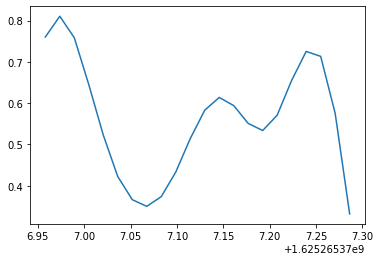

In [3]:
#%matplotlib qt
%matplotlib inline

plt.plot(bvp_timestamp, bvp_data)

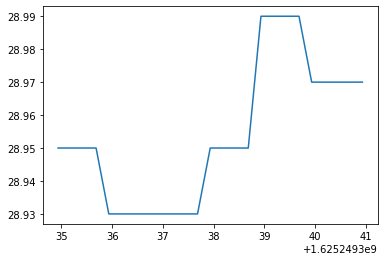

In [19]:
#%matplotlib qt
%matplotlib inline

plt.plot(temp_timestamp, temp_data)

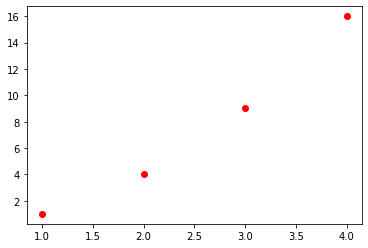

In [46]:
plt.plot([1, 2, 3, 4], [1, 4, 9, 16], 'ro')
plt.show()


In [72]:
%matplotlib qt

plt.figure(2)
plt.subplot()
plt.plot([1,2,3])

In [71]:
%matplotlib qt

plt.figure(1)
plt.subplot()
plt.plot([4,5,6])

In [32]:
plt.cla()

plt.figure(1)                # the first figure
plt.subplot(211)             # the first subplot in the first figure
plt.plot([1, 2, 3])
plt.subplot(212)             # the second subplot in the first figure
plt.plot([4, 5, 6])
plt.show()



In [31]:
plt.clf()

In [10]:
plt.cla

<function matplotlib.pyplot.cla()>

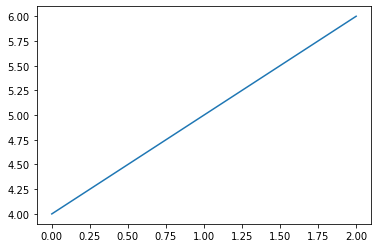

In [61]:
plt.plot([1,2,3])

plt.cla()
plt.plot([4,5,6])


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
plt.ion() ## Note this correction
fig=plt.figure()
plt.axis([0,1000,0,1])

i=0
x=list()
y=list()

while i <1000:
    temp_y=np.random.random();
    x.append(i);
    y.append(temp_y);
    plt.scatter(i,temp_y);
    i+=1;
    plt.show()
    plt.pause(0.0001) #Note this correction

In [24]:
from datetime import datetime

test = datetime.fromtimestamp(temp_timestamp[0])
print(test)

2021-07-02 11:25:18.979270


In [39]:
test2 = []
for i in range(len(temp_timestamp)):
    test2.append(datetime.fromtimestamp(temp_timestamp[i]))



#test2 = datetime.fromtimestamp(temp_timestamp)
print(test2)

[datetime.datetime(2021, 7, 2, 11, 25, 18, 979270), datetime.datetime(2021, 7, 2, 11, 25, 19, 229290), datetime.datetime(2021, 7, 2, 11, 25, 19, 479300), datetime.datetime(2021, 7, 2, 11, 25, 19, 729310), datetime.datetime(2021, 7, 2, 11, 25, 19, 979320), datetime.datetime(2021, 7, 2, 11, 25, 20, 229330), datetime.datetime(2021, 7, 2, 11, 25, 20, 479340), datetime.datetime(2021, 7, 2, 11, 25, 20, 729350), datetime.datetime(2021, 7, 2, 11, 25, 20, 979370), datetime.datetime(2021, 7, 2, 11, 25, 21, 229380), datetime.datetime(2021, 7, 2, 11, 25, 21, 479390), datetime.datetime(2021, 7, 2, 11, 25, 21, 729400), datetime.datetime(2021, 7, 2, 11, 25, 21, 979410), datetime.datetime(2021, 7, 2, 11, 25, 22, 229420), datetime.datetime(2021, 7, 2, 11, 25, 22, 479440), datetime.datetime(2021, 7, 2, 11, 25, 22, 729450), datetime.datetime(2021, 7, 2, 11, 25, 22, 979460), datetime.datetime(2021, 7, 2, 11, 25, 23, 229470), datetime.datetime(2021, 7, 2, 11, 25, 23, 479480), datetime.datetime(2021, 7, 2, 

In [41]:
print(test2[8])

2021-07-02 11:25:20.979370
